# N步时序差分方法在21点纸牌游戏上的应用（Black Jack Games）

参考了openAI开源GYM框架，对于这个游戏的环境进行python重构

In [1]:
import random
import numpy as np
import pandas as pd
from collections import defaultdict

In [2]:
class card:#Define a card class with card value function in 21-points game
    names = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']
    def __init__(self, card_name:str):
        self.name = card_name
        self.value = self.map_value(card_name)
    
    def map_value(self, card_name:str):
        if card_name == 'A':
            return 1
        elif card_name in ['J', 'Q', 'K']:
            return 10
        else:
            return int(card_name)

class cards(card):#Define a card library function with draw card function
    
    def __init__(self):
        self.remain_cards = self.names * 4

    def draw_card(self)->card:
        random.shuffle(self.remain_cards)
        picked_card = card(self.remain_cards[0])
        self.remain_cards.pop(0)
        return picked_card

def hand_value(hand:list)->int:
    values = [card.value for card in hand]
    names = [card.name for card in hand]
    total = sum(values)
    if 'A' in names and total <= 11:
        total += 10
    return total

In [3]:
class BlackJackEnv():
    
    def __init__(self):
        self.deck = cards()
        self.player = list()
        self.dealer = list()
        for i in range(2):#Each player receive 2 cards initially
            self.player.append(self.deck.draw_card())
            self.dealer.append(self.deck.draw_card())
        self.dealer_shown = self.dealer[-1].value

    def step(self, action):
        if action == 'hit':
            self.player.append(self.deck.draw_card())
            if hand_value(self.player) > 21:
                reward = -1
                done = True
            # elif 
            else:
                reward = 0
                done = False
        if action == 'stay':
            done = True
            while hand_value(self.player) < 17:
                self.dealer.append(self.deck.draw_card())
            player_value = hand_value(self.player)
            dealer_value = hand_value(self.dealer)
            if dealer_value > 21:
                reward = 1
            # elif hand_value(self.dealer) == 21 and len(self.dealer) == 2: # Black Jack Situation
            #     reward = -1.5 if self.natural else 0.5
            else:
                if player_value > dealer_value:
                    reward = 1
                elif player_value == dealer_value:
                    reward = 0
                else:
                    reward = -1
        hand_names = [card.name for card in self.player]
        player_ace = True if 'A' in hand_names else False
        next_state = (hand_value(self.player), self.dealer_shown, player_ace)
        
        return next_state, reward, done
    
    def reset(self):
        self.deck = cards()
        self.player = list()
        self.dealer = list()
        for i in range(2):#Each player receive 2 cards initially
            self.player.append(self.deck.draw_card())
            self.dealer.append(self.deck.draw_card())
        player_value = hand_value(self.player)
        self.dealer_shown = self.dealer[-1].value
        hand_names = [card.name for card in self.player]
        player_ace = True if 'A' in hand_names else False
        return (player_value, self.dealer_shown, player_ace)
        

In [4]:
actions=dict({0 : 'stay', 1 : 'hit'})
class Sarsa:#Learn a policy from Sarsa 
    def __init__(self, arg_dict):
        self.sample_count = 0
        self.n_actions = arg_dict['n_actions']
        self.lr = arg_dict['lr']
        self.gamma = arg_dict['gamma']
        self.epsilon = arg_dict['epsilon']
        self.Q_table = defaultdict(lambda: np.zeros(self.n_actions))
    
    def sample_action(self, state): #e-greedy algorithm
        self.sample_count += 1
        return np.argmax(self.Q_table[state]) \
            if np.random.uniform(0, 1) > self.epsilon \
            else np.random.choice(self.n_actions)

    def predict_action(self, state):
        return np.argmax(self.Q_table[str(state)])
    
    def update(self, state, action, reward, next_state, next_action, done):
        Q_predict = self.Q_table[state][action]
        if done:
            Q_target = reward
        else:
            Q_target = reward + self.gamma * \
                self.Q_table[next_state][next_action]
        #Sarsa 核心的更新函数
        self.Q_table[state][action] += self.lr * (Q_target - Q_predict)

def train(arg_dict:dict, env:BlackJackEnv, agent:Sarsa):
    rewards = []
    steps = []
    for epoch in range(arg_dict['train_epochs']):
        ep_reward = 0 # 记录积累的奖励
        ep_step = 0 # 记录总步数
        state = env.reset()
        action = agent.sample_action(state)
        while True:
            next_state, reward, done = env.step(action)
            next_action = agent.sample_action(next_state)
            agent.update(state, action, reward, next_state, next_action, done)
            state = next_state
            action = next_action
            ep_reward += reward
            ep_step += 1
            if done:
                break
        rewards.append(ep_reward)
        steps.append(ep_step)
        if (epoch + 1) % 10 == 0:
            print( f'Epoch: {epoch + 1}/{arg_dict["train_epochs"]}, Reward: {ep_reward:.2f}, Steps:{ep_step}, Epislon: {agent.epsilon:.3f}')
    return {'episodes': range(len(rewards)), 'rewards': rewards, 'steps': steps}
    

In [5]:
class NstepTD:
    def __init__(self, n, alpha, gamma):
        self.n = n
        self.alpha = alpha
        self.gamma = gamma
        self.V = defaultdict(lambda : 0)
    
    def policy(self, hand:list):
        if hand_value(hand) < 17:
            return 'hit'
        else:
            return 'stay'
    
    def learn(self, episode:int, env:BlackJackEnv):
        state = env.reset()
        rewards = np.zeros(10)
        states = [0] * 10
        states[0] = state
        T = 10000
        t = 0
        while True:
            if t < T:
                action = self.policy(env.player)
                next_state, reward, done = env.step(action)
                if hand_value(env.player) == 2:
                    print('Error:')
                    for card in env.player:
                        print(card.name, end='.')
                rewards[t+1] = reward
                states[t+1] = next_state
                if done:
                    T = t + 1
            dt = t - self.n + 1
            if dt == T - 1:
                break
            if dt >= 0:
                G = np.sum([self.gamma ** (i - dt - 1) * rewards[i] for i in range(dt + 1, min(dt + self.n, T) + 1)])
                if dt + self.n < T:
                    G = G + self.gamma ** self.n * self.V[states[dt + self.n]]
                self.V[states[dt]] = self.V[states[dt]] + self.alpha * (G - self.V[states[dt]])
            t += 1

### 考虑了玩家手里牌的点数，庄家的明牌和玩家手里是否有A, 一共有280种状态

### 时序误差差分之和来替代先前的误差项

In [6]:
class NstepTD_changed:
    def __init__(self, n, alpha, gamma):
        self.n = n
        self.alpha = alpha
        self.gamma = gamma
        self.V = defaultdict(lambda : 0)
    
    def policy(self, hand:list):
        if hand_value(hand) < 17:
            return 'hit'
        else:
            return 'stay'
    
    def learn(self, episode:int, env:BlackJackEnv):
        state = env.reset()
        rewards = np.zeros(10)
        states = [0] * 10
        states[0] = state
        T = 10000
        t = 0
        while True:
            if t < T:
                action = self.policy(env.player)
                next_state, reward, done = env.step(action)
                if hand_value(env.player) == 2:
                    print('Error:')
                    for card in env.player:
                        print(card.name, end='.')
                rewards[t+1] = reward
                states[t+1] = next_state
                if done:
                    T = t + 1
            dt = t - self.n + 1
            if dt == T - 1:
                break
            if dt >= 0:
                #G = np.sum([self.gamma ** (i - dt - 1) * rewards[i] for i in range(dt + 1, min(dt + self.n, T) + 1)])
                ###修改G，使得每次增加的不是reward而是时序差分误差
                G = np.sum([self.gamma ** (i - dt - 1) * (rewards[i] - self.V[states[i]] + self.gamma * self.V[states[i + 1]]) for i in range(dt + 1, min(dt + self.n, T) + 1)])
                if dt + self.n < T:
                    G = G + self.gamma ** self.n * self.V[states[dt + self.n]]
                self.V[states[dt]] = self.V[states[dt]] + self.alpha * (G - self.V[states[dt]])
            t += 1

In [7]:
agent = NstepTD(n=2, alpha=0.01, gamma=0.9)
env = BlackJackEnv()
for episode in range(500000):
    agent.learn(episode, env)
len(agent.V)

280

In [10]:
Baseline = agent.V

In [40]:
import matplotlib.pyplot as plt

alphas = [0, 0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
normal_e = list()
changed_e = list()
for alpha in alphas:
    errors = 0
    for i in range(100):
        agent = NstepTD(n=3, alpha=alpha, gamma=0.9)
        env = BlackJackEnv()
        for episode in range(100):
            agent.learn(episode, env)
            if episode > 90:
                error = 0
                for state in Baseline.keys():
                    error += (agent.V[state] - Baseline[state]) ** 2
                error /= len(Baseline)
                error = np.sqrt(error)
                errors += error
    normal_e.append(errors / 100)

    errors = 0
    for i in range(100):
        agent_new = NstepTD_changed(n=3, alpha=alpha, gamma=0.9)
        env = BlackJackEnv()
        for episode in range(100):
            agent_new.learn(episode, env)
            if episode > 90:
                error = 0
                for state in Baseline.keys():
                    error += (agent_new.V[state] - Baseline[state]) ** 2
                error /= len(Baseline)
                error = np.sqrt(error)
                errors += error
    changed_e.append(errors / 100)

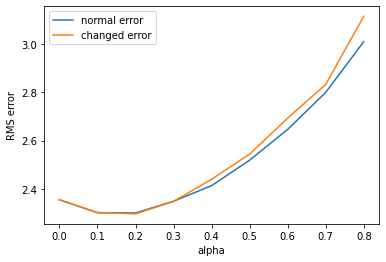

In [41]:
plt.plot(alphas, normal_e, label='normal error')
plt.plot(alphas, changed_e, label='changed error')
plt.xlabel('alpha')
plt.ylabel('RMS error')
plt.legend()

### 明显看到在多幕学习之后，修改后的算法误差损失明显比修改前的要差